## Setup

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn transformers torch

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.1 MB 882.6 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/10.1 MB 987.4 kB/s eta 0:00:10
   ---- ----------------------------------- 1.0/10.1 MB 914.5 kB/s eta 0:00:10
   ---- ----------------------------------- 1.0/10.1 MB 914.5 kB/s eta 0:00:10
   ----- ---------------------------------- 1.3/10.1 MB 828.3 kB/s eta 0:00:11
   ----- ---------------------------------- 1.3/10.1 MB 828.3 kB/s eta 0:00:11
   ------ --------------------------------- 1.6/10.1 MB 814.1 kB/s eta 0:00:11
   ------- -------------------------------- 1.8/10.1 MB 867.5 kB/s eta 0:00:10
   -------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset

C:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [4]:
data = pd.read_csv('data/train.csv')

print("Data Shape:", data.shape)
print("Data Info:")
data.info()
print("Data Head:")
print(data.head())

print("\nMissing Values:")
print(data.isnull().sum())

Data Shape: (57477, 9)
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB
Data Head:
       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-tur

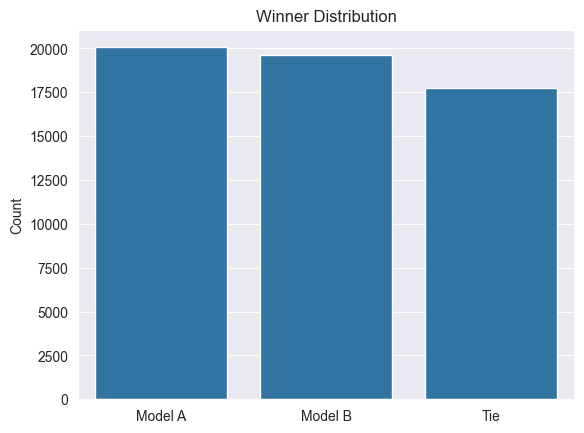

In [5]:
winner_columns = ['winner_model_a', 'winner_model_b', 'winner_tie']
labels = ['Model A', 'Model B', 'Tie']
counts = data[winner_columns].sum()
sns.barplot(x=labels, y=counts)
plt.title("Winner Distribution")
plt.ylabel("Count")
plt.show()

## Data processing 

In [6]:
data['winner'] = data[winner_columns].idxmax(axis=1)
data['response_combined'] = data['response_a'] + " [SEP] " + data['response_b']

le = LabelEncoder()
data['winner_encoded'] = le.fit_transform(data['winner'])

X_train, X_val, y_train, y_val = train_test_split(
    data[['prompt', 'response_combined']], 
    data['winner_encoded'], 
    test_size=0.2, 
    random_state=42
)

## Extraction

In [7]:
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train['response_combined'])
X_val_tfidf = tfidf.transform(X_val['response_combined'])

## Model Training

In [8]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

y_val_pred_rf = rf_model.predict_proba(X_val_tfidf)
logloss_rf = log_loss(y_val, y_val_pred_rf)
print(f"Random Forest Validation Log Loss: {logloss_rf}")


Random Forest Validation Log Loss: 1.0835986694468471


## Fine-tuning

In [9]:
class ChatDataset(Dataset):
    def __init__(self, prompts, responses, targets, tokenizer, max_len):
        self.prompts = prompts
        self.responses = responses
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, item):
        prompt = self.prompts[item]
        response = self.responses[item]
        target = self.targets[item]

        encoding = self.tokenizer(
            text=prompt,
            text_pair=response,
            add_special_tokens=True,
            max_length=self.max_len,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

## Parameters

In [10]:
PRE_TRAINED_MODEL = 'bert-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [11]:
train_dataset = ChatDataset(
    prompts=X_train['prompt'].values,
    responses=X_train['response_combined'].values,
    targets=y_train.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = ChatDataset(
    prompts=X_val['prompt'].values,
    responses=X_val['response_combined'].values,
    targets=y_val.values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Optimizer

In [13]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# Use PyTorch's AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

# Loss function
loss_fn = CrossEntropyLoss().to(device)


## Trainig

In [14]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        loss = loss_fn(logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

## Evaluation

In [15]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            loss = loss_fn(logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

## Proces

In [ ]:
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

Epoch 1/3


## Save model

In [ ]:
model.save_pretrained('.data/fine_tuned_model')
tokenizer.save_pretrained('.data/fine_tuned_model')

## Submission

In [ ]:
test_data = pd.read_csv('data/test.csv')

test_data['response_combined'] = test_data['response_a'] + " [SEP] " + test_data['response_b']
test_tfidf = tfidf.transform(test_data['response_combined'])

rf_predictions = rf_model.predict_proba(test_tfidf)

def generate_transformer_predictions(test_data, model, tokenizer, max_len, device):
    test_dataset = ChatDataset(
        prompts=test_data['prompt'].values,
        responses=test_data['response_combined'].values,
        targets=[0] * len(test_data),  # Dummy targets
        tokenizer=tokenizer,
        max_len=max_len
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    predictions = []
    model.eval()
    with torch.no_grad():
        for d in test_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            predictions.extend(probs.cpu().numpy())
    return np.array(predictions)

In [ ]:
transformer_predictions = generate_transformer_predictions(test_data, model, tokenizer, MAX_LEN, device)

final_predictions = (rf_predictions + transformer_predictions) / 2

submission = pd.DataFrame(final_predictions, columns=['winner_model_a', 'winner_model_b', 'winner_tie'])
submission.insert(0, 'id', test_data['id'])

In [ ]:
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' has been created.")